In [1]:
import cv2
import numpy as np
import scipy as sp
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
#% matplotlib notebook
% matplotlib inline

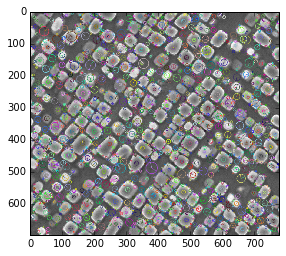

In [2]:
img = cv2.imread('MicrographsClean/Superalloy/SA3.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,img,flags=4)
#cv2.imwrite('sift_keypoints.jpg',img)
plt.imshow(img)

## Develop dictionary 

### Get information of files for training and testing 

In [3]:
folders = ['BasketWeave','Superalloy','Equiaxed','Eutectic','Bainite']
ninfolder = [11,9,8,5,6]
folderstub = ['BW', 'SA', 'Eq', 'Eu', 'Ba']
holdout = [3,3,3,2,1]
nfoldersuse = 2

files = []
folderid = []
for s in range(nfoldersuse):
    for t in range(holdout[s],ninfolder[s]):
        files.append(folders[s] + '/' + folderstub[s] + str(t+1) + '.jpg')
        folderid.append(s)
nfiles = len(files)

testfiles = []
testfolderid = []
for s in range(nfoldersuse):
    for t in range(holdout[s]):
        testfiles.append(folders[s] + '/' + folderstub[s] + str(t+1) + '.jpg')
        testfolderid.append(s)
ntestfiles = len(testfiles)



In [37]:
print(files)
print(testfiles)

['BasketWeave/BW4.jpg', 'BasketWeave/BW5.jpg', 'BasketWeave/BW6.jpg', 'BasketWeave/BW7.jpg', 'BasketWeave/BW8.jpg', 'BasketWeave/BW9.jpg', 'BasketWeave/BW10.jpg', 'BasketWeave/BW11.jpg', 'Superalloy/SA4.jpg', 'Superalloy/SA5.jpg', 'Superalloy/SA6.jpg', 'Superalloy/SA7.jpg', 'Superalloy/SA8.jpg', 'Superalloy/SA9.jpg']
['BasketWeave/BW1.jpg', 'BasketWeave/BW2.jpg', 'BasketWeave/BW3.jpg', 'Superalloy/SA1.jpg', 'Superalloy/SA2.jpg', 'Superalloy/SA3.jpg']


### Build feature set for clustering 

In [4]:
features = []
pts = []
imgid = []
msid = []

for s in range(nfiles):
    #print(files[s])
    img = cv2.imread('MicrographsClean/' + files[s])
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    #print(len(des))
    for r in range(len(des)):
        features.append(des[r,:].tolist())
        pts.append([kp[r].pt[0],kp[r].pt[1],kp[r].size,kp[r].angle])
        imgid.append(s)
        msid.append(folderid[s])

features = np.array(features)
pts = np.array(pts)
msid = np.array(msid)
#print(np.shape(features))

In [5]:
# dir(kp[0])
# print(kp[0].size,kp[0].angle,kp[0].pt, type(kp[0].pt))
# print(pts[0:10,2:4])
# print(msid)

In [71]:
from sklearn.cluster import KMeans
nclusters = 30
kmeans = KMeans(n_clusters=nclusters)
kmeans.fit(features[:,:])
print(np.shape(kmeans.labels_))
print(np.shape(kmeans.cluster_centers_))

(3655,)
(30, 128)


### Construct fingerprints of training data

In [72]:
trainx = np.zeros((nfiles,nclusters),dtype=float)
trainy = np.zeros(nfiles, dtype=int)
for s in range(nfiles):
    features = []
    img = cv2.imread('MicrographsClean/' + files[s])
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    #print(len(des))
    for r in range(len(des)):
        features.append(des[r,:].tolist())
    features = np.array(features)
    labels = kmeans.predict(features[:,:])
    unique, counts = np.unique(labels, return_counts=True)
    for t in range(len(unique)):
        trainx[s,unique[t]] = counts[t]
        trainy[s] = folderid[s]
    trainx[s,:] = trainx[s,:]/np.sum(trainx[s,:])
#print(trainx)
#print(trainy)
print(np.shape(trainx))
print(np.shape(trainy))
#print(np.sum(trainx))

(14, 30)
(14,)


### Train SVM

In [73]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import chi2_kernel

# Custom kernel
def chi2_distance(X, Y):
    return 0.5*np.sum((X-Y)**2/(X+Y+1e-6))

#print(np.shape(trainx[0]))
#print(np.shape(trainx[1]))

#svm = SVC(kernel=chi2_distance).fit(trainx,trainy)
svm = SVC(kernel=chi2_kernel, C=1.0, gamma=1.0).fit(trainx,trainy)
#svm = SVC(kernel='polynomial').fit(trainx,trainy)

labels = svm.predict(trainx)
print(trainy)
print(labels==trainy)

fitx = np.zeros((ntestfiles,nclusters),dtype=float)
fity = np.zeros(ntestfiles, dtype=int)
predicty = np.zeros(ntestfiles, dtype=int)
for s in range(ntestfiles):
    features = []
    img = cv2.imread('MicrographsClean/' + testfiles[s])
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    for r in range(len(des)):
        features.append(des[r,:].tolist())
    features = np.array(features)
    labels = kmeans.predict(features[:,:])
    unique, counts = np.unique(labels, return_counts=True)
    for t in range(len(unique)):
        fitx[s,unique[t]] = counts[t]
        fity[s] = testfolderid[s]
    fitx[s,:] = fitx[s,:]/np.sum(fitx[s,:])
    # Predict here!!
    labels = svm.predict(fitx)

print(fity)    
print(labels==fity)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[0 0 0 1 1 1]
[ True  True  True  True  True  True]


### Check fingerprints

In [74]:
#Establish a sensible ordering (8 + 6 images)
#orderscore = np.sum(trainx[:ninfolder[0]-holdout[0],:],axis=0) - np.sum(trainx[ninfolder[0]-holdout[0]:ninfolder[0]+ninfolder[1]-holdout[1],:],axis=0)
orderscore = np.sum(trainx[:ninfolder[0]-holdout[0],:],axis=0) - np.sum(trainx[ninfolder[0]-holdout[0]:ninfolder[0]-holdout[0]+ninfolder[1]-holdout[1],:],axis=0)

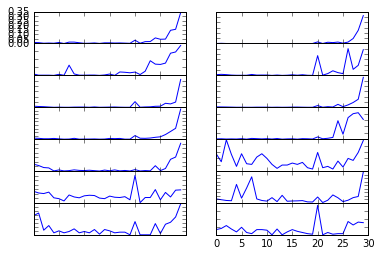

In [75]:
orderid = np.argsort(orderscore)
#for i in range(8,14):

nplots = 14
nrows = 7
ncols = 2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols)

plotidx = 0
for row in ax:
    for col in row:
        col.plot(trainx[plotidx,orderid])
        plotidx = plotidx + 1

fig.subplots_adjust(hspace=0)
plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()


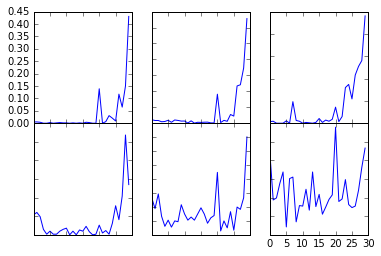

In [76]:
nplots = 6
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows,ncols=ncols)

plotidx = 0
for row in ax:
    for col in row:
        col.plot(fitx[plotidx,orderid])
        plotidx = plotidx + 1

fig.subplots_adjust(hspace=0)
plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()



# Code below duplicates some above 

### Check SVM on training data 

In [39]:
labels = svm.predict(trainx)
print(labels)
print(trainy)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1]


### Classify test images

In [35]:
fitx = np.zeros((ntestfiles,nclusters),dtype=int)
fity = np.zeros(ntestfiles, dtype=int)
predicty = np.zeros(ntestfiles, dtype=int)
for s in range(ntestfiles):
    features = []
    img = cv2.imread('MicrographsClean/' + testfiles[s])
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    #print(len(des))
    for r in range(len(des)):
        features.append(des[r,:].tolist())
    features = np.array(features)
    labels = kmeans.predict(features[:,:])
    unique, counts = np.unique(labels, return_counts=True)
    for t in range(len(unique)):
        fitx[s,unique[t]] = counts[t]
        fity[s] = testfolderid[s]
    fitx[s,:] = fitx[s,:]/np.sum(fitx[s,:])
    # Predict here!!
    labels = svm.predict(fitx)

In [40]:
print(labels)
print(fity)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1]
[0 0 0 1 1 1]


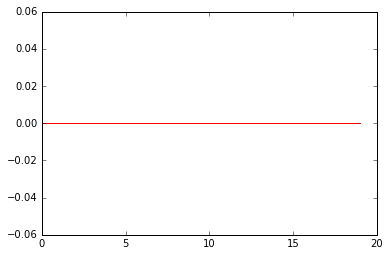

In [41]:
for i in range(3):
    plt.plot(fitx[i,orderid])